# Housing Price Predictor

## Configuration

In [42]:
# Librairies

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import numpy as np
from xgboost import XGBRegressor
import joblib

## Global

In [43]:
# Constants

from constants import *

In [44]:
# Functions

def analyse(data):
	nas = data.isna().sum()
	nuniques = data.nunique()
	types = data.dtypes
	
	return pd.DataFrame({
		"NA": nas,
		"Uniques": nuniques,
		"types": types
	})

def clean(data):
	# Data Selection
	data = data[data[DATA_NATURE_MUTATION_COLUMN] == DATA_NATURE_MUTATION_VENTE_VALUE]
	data = data[data[DATA_TYPE_LOCAL_COLUMN].isin(DATA_TYPE_LOCAL_VALUE)]

	# Data Cleaning
	data = data.dropna()

	return data

def merge(data_chunks, clean_func, columns):
	data = pd.DataFrame(columns=columns)

	for data_chunk in data_chunks:
		data_chunk = clean_func(data_chunk)
		data = pd.concat([data_chunk, data])
		if data.shape[0] >= DATA_SIZE:
			break
	
	data = data.drop([DATA_NATURE_MUTATION_COLUMN], axis=1)
	data = data.reset_index(drop=True)

	return data

## Data

### Data Retrieval

In [45]:
# Data Retrieval

columns = DATA_COLUMNS
data_chunks = pd.read_csv(DATA_FILE_PATH, sep=DATA_SEP_CHAR, usecols=columns, chunksize=DATA_CHUNK_SIZE)

# Geo Features Data

geo_columns = GEO_DATA_COLUMNS
data_geo = pd.read_csv(GEO_DATA_FILE_PATH, sep=GEO_DATA_SEP_CHAR, usecols=geo_columns)

In [46]:
# Data Preparation

data = merge(data_chunks, clean, columns)
y = data[DATA_VALEUR_FONCIERE_COLUMN].str.replace(",", ".").astype(float)
x = data.copy().drop([DATA_VALEUR_FONCIERE_COLUMN], axis=1)

data_geo = data_geo.dropna()

/tmp/ipykernel_896661/861951741.py:29: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data = pd.concat([data_chunk, data])


In [47]:
# Analysis

analyse(data)

,NA,Uniques,types
Date mutation,0,314,object
Valeur fonciere,0,14620,object
Code postal,0,1037,float64
Code commune,0,800,object
Type local,0,2,object
Surface reelle bati,0,455,float64
Nombre pieces principales,0,25,float64
Surface terrain,0,4862,float64


In [48]:
# Anaysis

analyse(data_geo)

,NA,Uniques,types
latitude,0,35921,float64
longitude,0,35921,float64
code_commune,0,908,float64


In [49]:
# Data Join

data = pd.merge(data, data_geo, left_on=DATA_CODE_COMMUNE_COLUMN, right_on=GEO_DATA_CODE_COMMUNE_COLUMN)

In [50]:
# Data Cleaning

data = data.drop([DATA_CODE_COMMUNE_COLUMN, GEO_DATA_CODE_COMMUNE_COLUMN], axis=1)

In [51]:
# Analysis

analyse(data)

,NA,Uniques,types
Date mutation,0,314,object
Valeur fonciere,0,14620,object
Code postal,0,1037,float64
Type local,0,2,object
Surface reelle bati,0,455,float64
Nombre pieces principales,0,25,float64
Surface terrain,0,4862,float64
latitude,0,35488,float64
longitude,0,35488,float64


### Data Preparation

#### Transformers

In [52]:
from transfomers import *

#### Transformation

In [53]:
# Data Transformation Pipeline

categorical_features = [DATA_CODE_POSTAL_COLUMN, DATA_TYPE_LOCAL_COLUMN]
numerical_features = [DATA_SURFACE_REELLE_COLUMN, DATA_SURFACE_TERRAIN_COLUMN, DATA_NB_PIECES_COLUMN]

column_transformer = ColumnTransformer(
	transformers=[
		("num", StandardScaler(), numerical_features + [DATA_TIME_COLUMN]),
		("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
	],
	remainder="passthrough"
)

transformation_pipeline = Pipeline([
	("type", TypeTransformer()),
	("date", DateTransformer()),
	("cols", column_transformer)
])

transformation_pipeline

,steps,"[('type', ...), ('date', ...), ...]"
,transform_input,None
,memory,None
,verbose,False
,str_features,"['Code postal', 'Type local']"
,num_features,"['Surface reelle bati', 'Surface terrain', ...]"
,date_column,'Date mutation'
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None


## Model Training

In [54]:
# Functions

def train_test(model, x, y):
	data_split = train_test_split(x, y)
	x_train, x_test, y_train, y_test = data_split

	# Training
	model.fit(x_train, y_train)

	# Validation
	train_pred = model.predict(x_train)

	train_results = (
		round(np.sqrt(mean_squared_error(y_train, train_pred)), 2),
		round(r2_score(y_train, train_pred), 2),
		round(mean_absolute_error(y_train, train_pred), 2)
	)

	# Test
	test_pred = model.predict(x_test)

	test_results = (
		round(np.sqrt(mean_squared_error(y_test, test_pred)), 2),
		round(r2_score(y_test, test_pred), 2),
		round(mean_absolute_error(y_test, test_pred), 2)
	)

	return model, data_split, train_pred, test_pred, train_results, test_results

def plot_results(y_train, train_pred, y_test, test_pred):
	fig, axs = plt.subplots(1, 2)
	axs[0].scatter(y_train, train_pred, s=10, color="black")
	axs[0].plot(
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		[min(y_train.min(), train_pred.min()), max(y_train.max(), train_pred.max())],
		color="red"
	)
	axs[0].set_title("Train")

	axs[1].scatter(y_test, test_pred, s=10, color="black")
	axs[1].plot(
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		[min(y_test.min(), test_pred.min()), max(y_test.max(), test_pred.max())],
		color="red"
	)
	axs[1].set_title("Test")

	fig.set_figwidth(15)
	fig.set_figheight(5)

### Linear Regression

In [55]:
# Training & Test

model = TransformedTargetRegressor(
	regressor=LinearRegression(),
	transformer=PowerTransformer("yeo-johnson")
)

main_pipeline = Pipeline([
	("trans", transformation_pipeline),
	("train", model)
])

lr_trained_model, data_split, train_pred, test_pred, train_results, test_results = train_test(main_pipeline, x, y)
_, _, y_train, y_test = data_split

In [56]:
# Model

model

,regressor,LinearRegression()
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,True
,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False
,method,'yeo-johnson'


In [57]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

Train - RAE : 1113611.16 - RMSE : 47666965.35 - R2 : -59.8
Test - RAE : 848780.68 - RMSE : 5089489.32 - R2 : 0.32


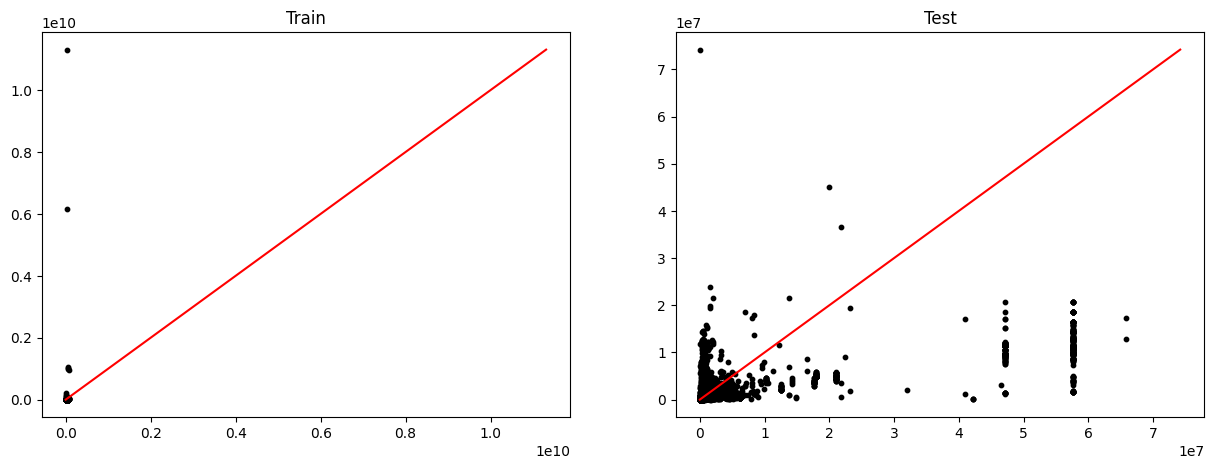

In [58]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)

### XGBoost

In [59]:
# Training & Test

model = TransformedTargetRegressor(
	regressor=XGBRegressor(),
	transformer=PowerTransformer("yeo-johnson")
)

main_pipeline = Pipeline([
	("trans", transformation_pipeline),
	("train", model)
])

xgb_trained_model, data_split, train_pred, test_pred, train_results, test_results = train_test(main_pipeline, x, y)
_, x_test, y_train, y_test = data_split

In [60]:
# Model

model

,regressor,"XGBRegressor(...ree=None, ...)"
,transformer,PowerTransformer()
,func,None
,inverse_func,None
,check_inverse,True
,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None


In [61]:
# Results

print(f"Train - RAE : {train_results[2]} - RMSE : {train_results[0]} - R2 : {train_results[1]}")
print(f"Test - RAE : {test_results[2]} - RMSE : {test_results[0]} - R2 : {test_results[1]}")

Train - RAE : 374580.4 - RMSE : 2267884.97 - R2 : 0.86
Test - RAE : 393548.58 - RMSE : 2433254.46 - R2 : 0.84


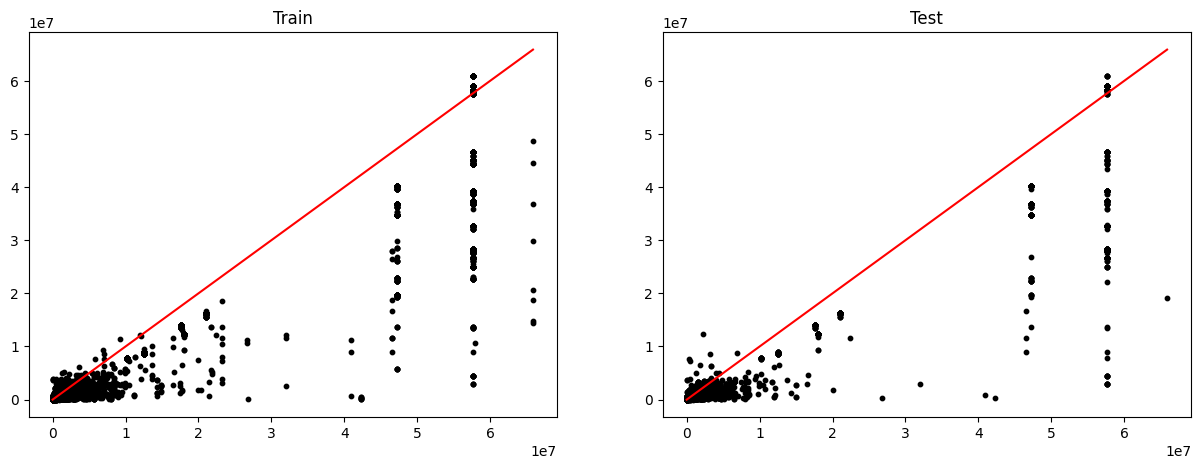

In [62]:
# Visualization

plot_results(y_train, train_pred, y_test, test_pred)

In [71]:
# Save

test = x_test.copy()
test[DATA_VALEUR_FONCIERE_COLUMN] = y_test
test = test.reset_index(drop=True)
test[DATA_CODE_POSTAL_COLUMN] = test[DATA_CODE_POSTAL_COLUMN].values.astype(int)
test[DATA_SURFACE_REELLE_COLUMN] = test[DATA_SURFACE_REELLE_COLUMN].values.astype(int)
test[DATA_SURFACE_TERRAIN_COLUMN] = test[DATA_SURFACE_TERRAIN_COLUMN].values.astype(int)
test[DATA_NB_PIECES_COLUMN] = test[DATA_NB_PIECES_COLUMN].values.astype(int)

joblib.dump(xgb_trained_model, XGB_MODEl_PATH, compress=1)
joblib.dump(test, XGB_TEST_SET, compress=1)

['./models/xgb_test']